In [65]:
import numpy,scipy.special
EP0=8.854187817*10**(-12) #真空介电常数F/m
H=6.62607015*10**(-34)
HBAR=H/(2*numpy.pi)
E=1.6*10**(-19)
C=3*10**8
PI=numpy.pi
PI2=numpy.pi*2

mm=10**(-3)
um=10**(-6)
nm=10**(-9)
pm=10**(-12)
fm=10**(-15)
km=10**3
mhz=10**6
ghz=10**9

print(scipy.pi)

3.141592653589793


##### 1、传输线的特征阻抗
<font size=2>

* 特征阻抗 $Z_0=\sqrt{L_0/C_0}$ ，单位长度的电感和电容分别为
    $$
    L_0=(60 \pi)^2 \epsilon_0 \frac{K(\sqrt{1-k^2})}{K(k)}
    \tag{1.1}
    $$
    $$
    C_0=2 \epsilon_0 (\epsilon^{sub}_r+1) \frac{K(k)}{K(\sqrt{1-k^2})}
    \tag{1.2}
    $$
    <img src="image/cpw.png" width="360px">
    
    （K 是第一类椭圆积分，$k=\frac{s}{s+2w}$，s 是中心导体的宽度，w 是导体距地面距离、沟宽。）

* 考虑air-bridge作用，bridge 与 CPW 中心导体形成平行板电容，额外的电容 $C_b= \frac{\epsilon_0 \epsilon^{insu}_rS}{dD}$ 会引入到特征阻抗的计算当中，修正结果
    $$
    Z_0= \sqrt{L_0/(C_0+C_b)}
    \tag{1.3}
    $$
    （S 是平行板电容的面积，d 是 bridge 和 CPW 之间绝缘层的厚度，$\epsilon^{insu}_r$ 是绝缘层的相对介电常数，长度为 D 的 CPW 上有一个 bridge。）

---
    e.g. 计算Z0
    蓝宝石er=10，s=10，w=5；硅er=11.9，s=10，w=6。
    阻抗模拟分别为52.9165，48.8644 ohm。
    
    bridge 的宽度 W=2um，CPW 的 w 为 5um，s 为10um，绝缘层的材质为高阻硅厚度为 250nm，衬底为蓝宝石。

<img src="image/z0-table.jpg" width="300px">

</font>

In [66]:
import scipy.special,numpy

# 传输线特征阻抗
def fun_z0(epsub,s0,w0): 
    s=s0*um # um
    w=w0*um

    k=s/(s+2*w)
    l0=(60*PI)**2*EP0*scipy.special.ellipk(numpy.sqrt(1-k**2))/scipy.special.ellipk(k) #第一类椭圆积分K(k)
    c0=2*EP0*(epsub+1)*scipy.special.ellipk(k)/scipy.special.ellipk(numpy.sqrt(1-k**2))
    z0=numpy.sqrt(l0/c0)
    return z0
# 传输线特征阻抗，带空气桥
def fun_z0_bridge(epsub,s0,w0,epinsu,ww0,d0,dd0): 
    s=s0*um # um
    w=w0*um
    k=s/(s+2*w)
    ww=ww0*um
    d=d0*nm # nm
    dd=dd0*um
    ss=ww*s

    l0=(60*PI)**2*EP0*scipy.special.ellipk(numpy.sqrt(1-k**2))/scipy.special.ellipk(k) #第一类椭圆积分K(k)
    c0=2*EP0*(epsub+1)*scipy.special.ellipk(k)/scipy.special.ellipk(numpy.sqrt(1-k**2))
    cb=EP0*epinsu*ss/d/dd
    z0=numpy.sqrt(l0/(c0+cb))
    # print("c0, cb: ", c0, cb)
    return z0

print("sapphire-z0: \nref 53, cal", fun_z0(10,10,5))
print("\nsi-z0: \nref 49, cal", fun_z0(11.9,10,6))
print("\nadd bridge: ")
for dd in range(10,70,10): 
    print(dd, fun_z0_bridge(10,10,5,11.9,2,250,dd))

sapphire-z0: 
ref 53, cal 52.91650051773072

si-z0: 
ref 49, cal 51.792959278048315

add bridge: 
10 20.446616684631522
20 26.97240630563695
30 31.077371770720976
40 33.98458978498537
50 36.17650801920224
60 37.89767780549763


##### 2、λ/4阻抗变换特性

<font size=2>

传输线方程由入射波+反射波两部分组成：
$$
u=A_1e^{\gamma z}e^{j\omega t}+A_2e^{-\gamma z}e^{j\omega t}\\
i=(A_1e^{\gamma z}e^{j\omega t}-A_2e^{-\gamma z}e^{j\omega t})/Z_0
\tag{2.1}
$$
输入阻抗
$$
Z_{in}=u(z,t)/i(z,t)=u(z)/i(z)=Z_0\frac{A_1e^{\gamma z}+A_2e^{-\gamma z}}{A_1e^{\gamma z}-A_2e^{-\gamma z}}
$$
* 考虑边界条件
    $$
    u(0)/i(0)=Z_0\frac{A_1+A_2}{A_1-A_2}\equiv Z_1\\
    i.e.\quad A_1/A_2=(Z_1+Z_0)/(Z_1-Z_0)
    $$
* 考虑无损耗传输 $\gamma=\alpha+j\beta\Rightarrow j\beta, where \quad \alpha=0$

输入阻抗化简为
$$
Z_{in}=Z_0\frac{Z_1+jZ_0\tan{\beta z}}{Z_0+jZ_1\tan{\beta z}}
\tag{2.2}
$$

</font>

可以看出，当 $z=k\frac{\pi}{\beta}=k\frac{\lambda}{2}, \quad \beta=2\pi/\lambda$ 时， $\beta z=k\pi \Rightarrow Z_{in}=Z_1$ 。该特性称作 $\lambda/2$ 阻抗重复性，下面画图展示。

In [67]:
import numpy

# 计算输入阻抗
def fun_zin(z,z0,z1,lamb):
    bet=PI2/(lamb*um) # um
    zin=z0*(z1+1j*z0*numpy.tan(bet*z*um))/(z0+1j*z1*numpy.tan(bet*z*um))
    return zin.real

lamb=4549
print(fun_zin(lamb/2,50,100,lamb))

100.0


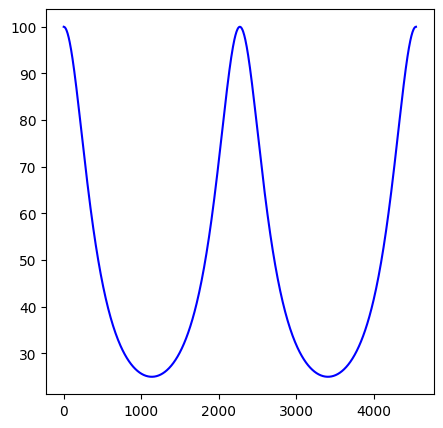

In [68]:
import matplotlib.pyplot as plt
import numpy
fig=plt.figure(figsize=(5,5))

lam=4543 # um
x=numpy.linspace(0,lam,1000)
y=fun_zin(x,50,100,4543)
ax=fig.add_subplot()
ax.plot(x,y,'b')
plt.show()

##### 3、反射系数和驻波比

<font size=2>

由传输方程 $(2.1)$ ，得出反射系数：
$$
\Gamma_u(z)=\frac{u^-}{u^+}=\frac{A_2}{A_1}e^{-2j\gamma z}=\frac{Z_1-Z_0}{Z_1+Z_0}e^{-2j\gamma z}=-\Gamma_i(z)
$$
令
$$
\Gamma=\frac{Z_1-Z_0}{Z_1+Z_0}=|\Gamma|e^{j\phi}
$$
阻抗匹配，负载阻抗=传输线特征阻抗，i.e.当 $Z_1=Z_0$ 时， $|\Gamma|=0$ ，无反射。

用反射系数表示电压驻波比VSWR： 
$$
\rho=\frac{1+|\Gamma|}{1-|\Gamma|}
$$

</font>

---
##### 4、全反射情况（开路、短路、纯电抗）阻抗变换

<font size=2>

当 $|\Gamma|=|\frac{Z_1-Z_0}{Z_1+Z_0}|=1$ 时，发生全反射，形成纯驻波。有以下三种情况：
1. $\Gamma=-1\Rightarrow Z_1=0$，对应终端短路，无负载。

    利用输入阻抗公式 $(2.2)$ 可得
    $$
    Z_{in}=Z_0\frac{Z_1+jZ_0\tan{\beta z}}{Z_0+jZ_1\tan{\beta z}}=jZ_0\tan{\beta z}
    $$
    ! 注意，此时计算仍是无损耗情况，考虑衰减常数 $\alpha$ 并不会对相位造成影响，但会让计算变得很复杂。

    并且会发现 $(Z_1-Z_0)/(Z_1+Z_0)=A_2/A_1=-1$ ，也就是说此时终端处 $u^-=-u^+$ ，说明入射波和反射波电压差一个 $\pi$ 的相位；相反，电流相等。

2. $\Gamma=1\Rightarrow Z_1\rightarrow\infty$，对应终端开路，负载无穷大。

    同样把 $Z_1$ 带入输入阻抗 $Z_{in}$ 得到
    $$
    Z_{in}=-j\frac{Z_0}{\tan{\beta z}}
    $$
    此时 $(Z_1-Z_0)/(Z_1+Z_0)=A_2/A_1=1$ ，终端处 $u^-=u^+$ ，说明入射波和反射波电压相等，但电流将差一个 $\pi$ 的相位。

3. 负载为纯电抗（虚数） $Z_1=jZ_x$ ， $|\Gamma|=|\frac{jZ_x-Z_0}{jZ_x+Z_0}|=1$。

    分析，略。
    
</font>
    
和有负载的情况一样，$Z_{in}$ 以 $\lambda/2$ 为周期变化，同时每经过 $\lambda/4$ 阻抗特性也发生变换，前两种情况曲线如下。

In [69]:
import numpy

# 计算短路阻抗
def fun_zin_short(z,z0,lamb):
    bet=PI2/(lamb*um)
    zin=1j*z0*numpy.tan(bet*z*um)
    return zin.imag

# 计算开路阻抗
def fun_zin_open(z,z0,lamb):
    bet=PI2/(lamb*um)
    if numpy.tan(bet*z*um)!=0:
        zin=-1j*z0/numpy.tan(bet*z*um)
        return zin.imag

print(fun_zin_short(100,50,4543))
print(fun_zin_open(100,50,4543))
print(fun_zin_open(0,50,4543))

6.9596700945357775
-359.2124290435572
None


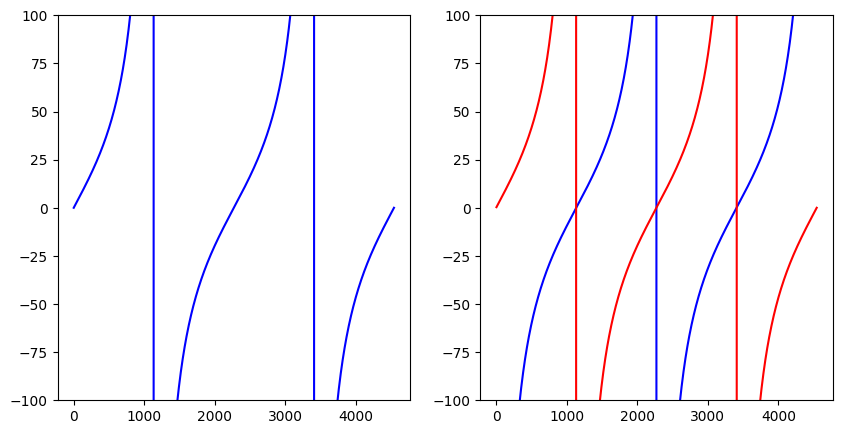

In [70]:
import matplotlib.pyplot as plt
import numpy
fig=plt.figure(figsize=(10,5))

lamb=4543 # um
x=numpy.linspace(0,lamb,1000)

y1=fun_zin_short(x,50,lamb)
ax1=fig.add_subplot(1,2,1)
ax1.plot(x,y1,'b')
ax1.set_ylim([-100,100])

# y2=fun_zin_open(x,50,lamb)
# 因为open函数NaN的存在，不管怎么处理画图都会出错
bet=PI2/(lamb*um)
mask=numpy.abs(numpy.tan(bet*x*um))!=0 # 筛选/=0的x点
x_cond=x[mask]
y2=-1*50/numpy.tan(bet*x_cond*um)
# 4分波长后open变short
y2_shif=-1*50/numpy.tan(bet*(x_cond+lamb/4)*um)
ax2=fig.add_subplot(1,2,2)
ax2.plot(x_cond,y2,'b')
ax2.plot(x_cond,y2_shif,'r')
ax2.set_ylim([-100,100])

plt.show()

##### 5、负载短路 λ/4 和开路 λ/2 传输线可等效为并联LCR谐振腔

在上图可以看到： short 和 open 阻抗曲线仅相差 $\lambda/4$ ， 且$\lambda(1/4+1/2k)$ 处的 short 和 $\lambda(1/2+1/2k)$ 处的 open 都具有并联 LCR 阻抗特性，接下来具体分析。

<font size=2>

串联型LCR阻抗：Z=R+iwL+1/iwC;

<img src="image/lcr-series.jpg" width="160px">

**并联型LCR阻抗：Z=1/(1/R+1/iwL+iwC);**

<img src="image/lcr-parallel.jpg" width="160px">

1. 对于短路 λ/4 传输线：$Z_l=0, λ/4 = πv/2ω_r$；

    ! **考虑有损耗的情况：α≠0；**

    其中 $v=c_0/\sqrt{(\epsilon_{sub}+1)/2}$ （*出现于 wang th 论文，存疑 ???*）
    $$
    Z_{in}^{\lambda/4}=Z_0 \tanh{[i(\pi/2+\pi\Delta\omega/2\omega_r)+\alpha \pi\nu/2\omega_r]}
    $$
    当损耗很小α≈0；在谐振频率附近 $Δω/ω_r≈0$；
    $$
    Z_{in}^{\lambda/4}=Z_0/(\alpha\pi\nu/2\omega_r+i\pi\Delta\omega/2\omega_r)
    $$
    等效并联LCR：$C=\pi/(4\omega_r Z_0), L=1/(\omega^2_rC)=4Z_0/\pi\omega_r$

2. 对于开路 λ/2 传输线：$Z_l→\infty, λ/2 = πv/ω_r$；
    $$
    Z_{in}^{\lambda/2}=Z_0/(\alpha\pi\nu/2\omega_r+i\pi\Delta\omega/\omega_r)
    $$
    等效并联LCR：$C=\pi/(2\omega_r Z_0), L=1/(\omega^2_rC)=2Z_0/\pi\omega_r$

---
    e.g. 计算CPW长度（波长）
    将共面波导的长度设计为波长的四分之一，衬底为高阻硅。
    6.5GHz 的四分之一共面波导的长度为 4543.2um。

</font>


In [71]:
import numpy

# 短路lambda/4传输线的电容、电感
def fun_lc_lamb4(wr0,z0):
    lc4=[0,0]
    wr=wr0*ghz # GHz
    lc4[0]=4*z0/PI/wr/nm # L nH
    lc4[1]=PI/4/wr/z0/fm # C fF
    return lc4
# 开路lambda/2传输线的电容、电感
def fun_lc_lamb2(wr0,z0):
    lc2=[0,0]
    wr=wr0*ghz
    lc2[0]=2*z0/PI/wr/nm
    lc2[1]=PI/2/wr/z0/fm
    return lc2
# 输入频率计算谐振波的波长
def fun_lamb(epsub,wr0):
    wr=wr0*ghz
    v=C/numpy.sqrt((epsub+1)/2)
    # v=c0/numpy.sqrt(epsub*1) # ur=1
    lamb=PI2*v/wr
    return lamb/um # um

# z0=zz0(11.9,10,5,11.9,2,250,40)
# print("阻抗：", z0)
wr=PI2*6.5
z0=50
print("6.5GHz, 50ohm")
print("\n短路1/4波长, 长度: ", fun_lamb(11.9,wr)/4, "um")
print("电感: ", fun_lc_lamb4(wr,z0)[0], "nH, 电容：", fun_lc_lamb4(wr,z0)[1], "fF")
print("\n开路1/2波长, 长度: ", fun_lamb(11.9,wr)/2, "um")
print("电感: ", fun_lc_lamb2(wr,z0)[0], "nH, 电容：", fun_lc_lamb2(wr,z0)[1], "fF")

6.5GHz, 50ohm

短路1/4波长, 长度:  4543.264793989372 um
电感:  1.5587874406513502 nH, 电容： 384.6153846153846 fF

开路1/2波长, 长度:  9086.529587978745 um
电感:  0.7793937203256751 nH, 电容： 769.2307692307692 fF


##### 6、谐振腔的品质因子
<font size=2>

谐振腔的品质因子（Quality Factor）描述了谐振腔中能量储存与能量损失之间的比例关系。
$$
1/Q=1/Q_i+1/Q_e
$$
   

1. 内部品质因子 $Q_i$ 描述谐振子由于内部电阻引起的能量损耗，主要由材料和微纳加工工艺决定，**在数值上远远高于外部品质因子，因子越高损耗越小。** 从功率的角度来看，带内阻的并联 LCR 谐振电路：Qi=无功功率/有功功率，
    $$
    Q_i=\frac{P_{wu}}{P_{you}}=\frac{(V^2/Z_0)}{(V^2/R)}=\frac{R}{Z_0}=\omega_rRC
    $$
    在谐振状态下，电感和电容中的能量不随时间变化，贮存的能量与时间 t 无关，它不再与外界交换能量，而是稳定地储存在电路中。电阻上消耗的能量应由外电路不断地输入有功功率来补偿。

2. 外部品质因子 $Q_c$ 来源于谐振腔与外部传输线的耦合。

    <img src="image/qc-external-factor.jpg" width="460px">

    在上图中，体系存储的平均能量 $C_rV_r^2/2$ 和能量耗散速率 $V_k^2/2Z_{ext}$ 。由于在一般情况下耦合电容的容抗 $Z_k=1/ω_rC_k$ 远大于传输线引起的外部阻抗 $Z_{ext}$ ，所以，
    $$
    \frac{V_k}{Z_{ext}}=\frac{V_r-V_k}{Z_k}=\frac{V_r}{Z_k}
    $$
    从能量角度来看：Qe=$2\pi$\*存储的能量 /（耗散速率\*T）=$\omega_r$\*存储的能量 / 耗散速率，（*和 wang th 结果一致，不过 $2\pi$的出现仍存疑 ???*）
    $$
    Q_e=\omega_r\frac{C_rV_r^2/2}{V_k^2/2Z_{ext}}=\frac{C_r}{\omega_rC_k^2Z_{ext}}
    $$
    **谐振腔的能量耗散主要来源于谐振腔与外部传输线的耦合，即外部品质因子的贡献。** 因此，外部品质因子作为主要因素，决定了谐振腔的能量耗散速率 $\gamma=\omega_r/Q_e$

***通过高低功率测试，可以判断材料的品质和加工工艺。这是由于在高功率信号下测量样品，内部缺陷达到饱和，测量的 Qi 比低功率下要高，而 Qc 由电路参数决定，在高低功率下的结果没有很大差别。***

</font>

---
##### 7、Purcell effect
<font size=2>

**谐振腔的能量耗散速率越大则测量信号的强度越强** ， 但是量子比特与谐振腔也有耦合，比特的能量也可能通过传输线耗散到环境中。这种两能级体系和腔的耦合后，腔的耗散引起两能级体系的能量耗散过程也被称为 Purcell effect。
因此，谐振腔的 $Q_c$ 也不宜设计过小。

为了兼顾读取信号强度和比特退相干时间，还可以在在谐振腔与环境之间额外增加了一个滤波器——Purcell filter，其通带频率在读取腔谐振频率附近，而阻带频率范围则覆盖了比特的谐振频率。

在 Purcell filter 存在的情况下，谐振腔的读取信号可以通过，而比特的能量泄露则被抑制。

</font>

##### 8、比特频率

<font size=2>

1. 对于 LC 谐振电路， $H=4E_Cn^2+\frac{1}{2}E_L\phi^2$ ，是 $\phi$ 的抛物线函数。

    ！ 注意，该式是算符形式。

    其中 $E_C=e^2/(2C)$ 是将 Cooper 对中的每个电子加到 island 上的电荷能量， $n=Q/2e$ 是 island 上附加的 Cooper 对数量。
    
    ！ 注，在上述定义中前后的单电子 / Cooper 的不一致，是该项前系数 “4” 的成因。

    $E_L=(\Phi _0/2\pi)^2/L$ 是电感能量, $\Phi_0=h/(2e)$ 是超导磁通量子， 磁通减少量 $\phi\equiv2\pi\Phi/\Phi _0$ 是穿过电感的规范不变相 “gauge-invariant phase”

    谐振器频率 $\omega_r=\sqrt{8E_LE_C}/\hbar=1/\sqrt{LC}$ ，能级分布 $E_{k+1}-E_k=\hbar\omega_r$ 。

    <img src="image/elc-eq.png" width="460px">

2. 对于量子比特，替换电感能为约瑟夫森结 $E_j$ 的能量， $H=4E_Cn^2+E_j\cos{\phi}$ 。

    $E_j=I_C\Phi _0/2\pi$ ，表示单电子穿过结的隧穿能量。 $I_C$ 是结的临界电流。
    
    $I_CR_n=\pi\Delta(0)/2e$ ， $R_n$ 是结的常温电阻， $\Delta(0)$ 是绝对零度下结的超导材料能隙。

    比特频率 $\omega_q=(\sqrt{8E_jE_C}-E_C)/\hbar$ ，非谐性 $\alpha=\omega _{21}-\omega _{10}=-E_C$ 。

---
    e.g. 求结的常温电阻
    Al 的超导能隙为 180ueV ，取比特频率 5.3GHz ，非谐 -230MHz。

</font>

In [72]:
# 计算结的临界电流、常温电阻，以及比特电容
def fun_ic_rn_c(delt0,omeq0,alph0):
    delt=delt0*E*um # ueV
    omeq=omeq0*PI2*ghz
    alph=alph0*PI2*mhz

    ec=-alph*HBAR
    ej=(HBAR*omeq+ec)**2/8/ec
    phi0=H/(2*E)
    ic=PI2*ej/phi0
    rn=PI*delt/(2*E)/ic
    c=E**2/(2*ec)

    rnc=[0,0,0]
    rnc[0]=ic/nm # nA
    rnc[1]=rn/km # kohm
    rnc[2]=c/fm # fF
    return rnc

print(fun_ic_rn_c(180,5.3,-230))


[33.416602010491864, 8.46116366751796, 83.98971434530236]


##### 9、色散读取
<font size=2>

<img src="image/dispersive-shift.jpg" width="360px">

（两能级、三能级、六能级模型下，谐振腔频率/腔内光子数随测量强度的变化，红线对应的是比特处于 |0⟩，蓝色虚线对应 |1⟩，灰色虚线对应 |2⟩。）

由于比特与读取腔耦合后，读取腔本身的频率发生变化，理论上很难测量到腔的本征频率。但是当读取腔内的光子数较多时，腔的频率逐渐接近本征频率。因此 $\omega_r$ 可以采用高功率进行快速标定。

在 $g/\Delta << 1$ 的色散区域（dispersive regime），谐振子的共振频率 $\omega_r$ 受量子比特影响产生位移（shift） $\chi$ ，其中 $\Delta=\omega_q-\omega_r$ 是量子比特和谐振子的频率差。

1. 对于两能级系统，低功率下的读取腔的频率在比特不同态下有区分，而光子数几乎没有区别。
    $$
    \chi=g^2/\Delta
    \tag{9.1}
    $$
    * 当 $q\rightarrow\ket{1}$ , 谐振腔的共振频率发生偏移 $\omega_r+\chi$
    * 当 $q\rightarrow\ket{0}$ , 谐振腔的共振频率发生偏移 $\omega_r-\chi$
    
2. 考虑到量子比特存在更高能级，在三能级模型中，不仅低功率下频率有区别，高功率下的光子数也有区别。
    $$
    \chi=g^2/\Delta(1+\Delta/(\omega_{21}-\omega_{10}))
    \tag{9.2}
    $$

---
    e.g. 求色散位移
    qubit 和 res 频率差 1GHz，耦合强度为 50MHz，非谐性 -230MHz。
    位移为 -0.467Mhz

</font>

In [73]:
# 计算色散位移量
def fun_shift2(delt0,g0):
    delt=delt0*PI2*ghz # GHz
    g=g0*PI2*mhz # MHz
    chi=g**2/delt
    return chi/PI2/mhz # MHz

# 高阶修正
def fun_shift3(delt0,g0,alph0):
    delt=delt0*PI2*ghz # GHz
    g=g0*PI2*mhz # MHz
    alph=alph0*PI2*mhz # MHz
    chi=g**2/delt/(1+delt/alph)
    return chi/PI2/mhz # MHz

print(fun_shift2(-1,50), "MHz")
print(fun_shift3(-1,50,-230), "MHz")

-2.5000000000000004 MHz
-0.467479674796748 MHz


/home/imybfu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


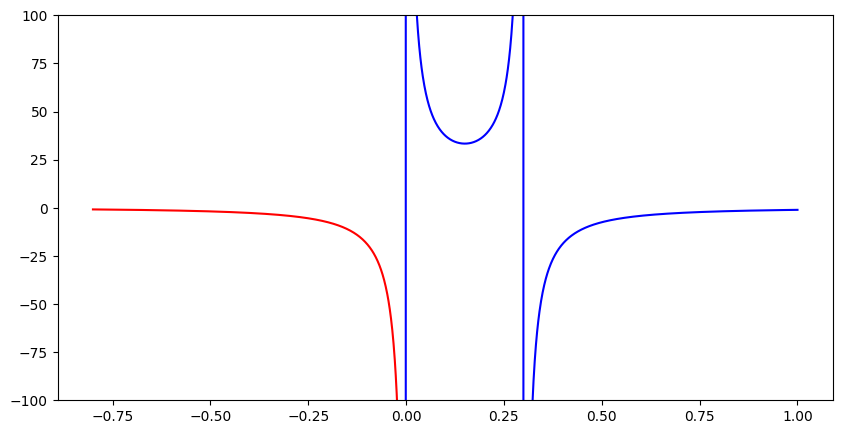

In [74]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10,5))
x1=numpy.linspace(-0.8,0,1000)
x2=numpy.linspace(-0.01,1,1000)
ax=fig.add_subplot()
# 红色部分一般的色散区域，失谐量<0，色散位移<0
ax.plot(x1,fun_shift3(x1,50,-300),'r')
ax.plot(x2,fun_shift3(x2,50,-300),'b')
ax.set_ylim([-100,100])
plt.show()

##### 10、比特与读取腔耦合

<font size=2>

<img src="image/couple-q-lcr.png" width="260px">

色散读取 $(9.1)(9.2)$ 中用到了比特和谐振腔的耦合系数，计算如下：
$$
g=C_g\frac{\sqrt{\omega_q\omega_r}}{2\sqrt{(C_q+C_g)(C_r+C_g)}}
\tag{10.1}
$$
! 对于比特间电容耦合，其强度计算方式同上

</font>

---
    e.g. 计算耦合强度
    取比特频率 5.5GHz ，电容 84.2fF ；读取腔频率 6.5GHz ，电容385fF ，耦合电容 3.3fF

In [75]:
import numpy

def fun_g_bit_res(omeq0,cq0,omer0,cr0,cg0):
    omeq=omeq0*PI2*ghz
    cq=cq0*fm
    omer=omer0*PI2*ghz
    cr=cr0*fm
    cg=cg0*fm
    g=cg*numpy.sqrt(omeq*omer)/2/numpy.sqrt((cq+cg)*(cr+cg))
    return g/PI2/mhz # mhz

print(fun_g_bit_res(5.5,84.2,6.5,385,3.3))

53.52223560888545


##### 11、比特间可调耦合

<font size=2>

<img src="image/couple-tunable.jpg" width="260px">

$$
g\approx \frac{g_{1c}g_{2c}}{2}(\frac{1}{\Delta _{1c}}+\frac{1}{\Delta _{2c}}-\frac{1}{\Sigma _{1c}}-\frac{1}{\Sigma _{2c}})+g_{12}
\tag{11.1}
$$
其中 $\Delta _{ic}=\omega_i-\omega_c, \quad \Sigma _{ic}=\omega_i+\omega_c$ ， $g_{ic}$ 的计算方式如式 $(10.1)$ 一致
$$
g_{ic}\approx C_{ic}\frac{\sqrt{\omega_i\omega_c}}{2\sqrt{(C_i+C_{ic})(C_c+C_{ic})}}
$$
$$
g_{12}=\frac{\sqrt{\omega _1\omega _2}}{2}(\frac{C_{12}}{\sqrt{C_1C_2}}+\frac{C_{1c}C_{2c}}{\sqrt{C_1C_2}C_c^2})
$$

</font>

##### 12、控制线耦合强度

<font size=2>

<img src="image/x-control.png" width="260px">

x-control 驱动强度为
$$
2g_d=\frac{C_dV_d}{C_q+C_d}\sqrt{\frac{1}{2\hbar Z_q}}
$$

其中， $C_d$ 是微波驱动电容， $V_d$ 是输入到芯片上的电压， $Z_q$ 是比特的特征阻抗
$$
Z_q=\frac{1}{\omega_qC_q}
$$
$C_q$ 的计算参考单位长度的电容 $(1.2)$ ，长度按 $4l_q$ 计算
$$
C_q=4l_qC_0=8l_q\epsilon_0 (\epsilon^{sub}_r+1) \frac{K(k)}{K(\sqrt{1-k^2})}
$$
利用上式以及非谐性 $\alpha=-E_C/\hbar=-e^2/(2C_q)/\hbar$ 可以计算出 bit 臂长

! 驱动强度一般 $g_d/2\pi>50MHz$ ，可以在 10ns 内完成单次激发。（？？from wang th p40，未找到两者关系）
</font>

    e.g. 计算驱动强度
    取输出电压 0.4V ，线上衰减 -60dB ，驱动电容 50fF。

In [76]:
import numpy

# 利用非谐性计算 bit 电容
def fun_cq(alph0):
    alph=alph0*PI2*mhz
    cq=-E**2/HBAR/alph/2
    return cq/fm # fF

# 利用 bit 频率以及 cq 计算臂长
def fun_lq(epsub,s0,w0,wq0,cq0):
    cq=cq0*fm
    s=s0*um # um
    w=w0*um
    k=s/(s+2*w)
    lq=cq*scipy.special.ellipk(numpy.sqrt(1-k**2))/scipy.special.ellipk(k)/(8*EP0*(epsub+1))
    return lq/um

# 计算驱动强度
def fun_g_drive(omeq0,cq0,cd0,vdstart,db):
    omeq=omeq0*PI2*ghz
    cq=cq0*fm
    cd=cd0*fm
    vd=vdstart*10**(db/10)
    zq=1/omeq/cq
    gd=cd*vd/(cq+cd)/numpy.sqrt(2*HBAR*zq)/2
    return gd/PI2/mhz

print(fun_cq(-230))
print(fun_lq(11.9,10,6,5.5,84))
print(fun_g_drive(5.5,84,50,0.4,-60))

83.98971434530235
128.30108068130002
44.062910147476735
